In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import seaborn as sns
from itertools import cycle
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score,recall_score, f1_score, roc_auc_score, roc_curve, auc, classification_report
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
data = pd.read_csv( 'sph6004_assignment1_data.csv')

# Display basic information about the dataset
data_info = data.info()

# Display the first few rows of the dataset to understand its structure
data_head = data.head()

data_info, data_head#数据展示

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13409 entries, 0 to 13408
Columns: 162 entries, id to weight_admit
dtypes: float64(158), int64(2), object(2)
memory usage: 16.6+ MB


(None,
          id  aki gender  admission_age                    race  \
 0  36570066    3      F      79.953141  BLACK/AFRICAN AMERICAN   
 1  39307659    0      F      78.194169         WHITE - RUSSIAN   
 2  38743306    2      F      65.602396                   WHITE   
 3  32339865    2      F      64.906629                 UNKNOWN   
 4  35526987    2      M      57.438861                   WHITE   
 
    heart_rate_min  heart_rate_max  heart_rate_mean  sbp_min  sbp_max  ...  \
 0            96.0           104.0       100.083333    103.0    126.0  ...   
 1            72.0           134.0        97.263158     97.0    127.0  ...   
 2            60.0            97.0        84.166667     95.0    143.0  ...   
 3            59.0            87.0        71.461538    113.0    150.0  ...   
 4            57.0           100.0        82.387097     81.0    127.0  ...   
 
    ggt_max  ld_ldh_min  ld_ldh_max  gcs_min  gcs_motor  gcs_verbal  gcs_eyes  \
 0      NaN       236.0       318.0   

In [3]:
missing_ratio = data.isnull().sum(axis=0)/data.shape[0]

missing_ratio_df = missing_ratio.reset_index()
missing_ratio_df.columns = ['Feature', 'MissingRatio']

missing_ratio_df.to_csv('missing_ratio.csv', index=False)

features_to_drop = missing_ratio[missing_ratio > 0.3].index

data = data.drop(columns=features_to_drop)

In [4]:
numerical_features = data.select_dtypes(include=['number']).columns.tolist()
categorical_features = data.select_dtypes(include=['object']).columns.tolist()

num_imputer = SimpleImputer(strategy='mean')
data[numerical_features] = num_imputer.fit_transform(data[numerical_features])

if categorical_features:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    data[categorical_features] = cat_imputer.fit_transform(data[categorical_features])

    encoder = OneHotEncoder(sparse=False, drop='first')
    encoded_cats = encoder.fit_transform(data[categorical_features])
    encoded_cats_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_features))

    data.drop(columns=categorical_features, inplace=True)
    data = pd.concat([data, encoded_cats_df], axis=1)

print(data.head())
print(data['aki'].value_counts())

           id  aki  admission_age  heart_rate_min  heart_rate_max  \
0  36570066.0  3.0      79.953141            96.0           104.0   
1  39307659.0  0.0      78.194169            72.0           134.0   
2  38743306.0  2.0      65.602396            60.0            97.0   
3  32339865.0  2.0      64.906629            59.0            87.0   
4  35526987.0  2.0      57.438861            57.0           100.0   

   heart_rate_mean  sbp_min  sbp_max    sbp_mean  dbp_min  ...  \
0       100.083333    103.0    126.0  116.136364     40.0  ...   
1        97.263158     97.0    127.0  109.833333     56.0  ...   
2        84.166667     95.0    143.0  112.153846     56.0  ...   
3        71.461538    113.0    150.0  138.160000     60.0  ...   
4        82.387097     81.0    127.0   97.672131     47.0  ...   

   race_PATIENT DECLINED TO ANSWER  race_PORTUGUESE  race_SOUTH AMERICAN  \
0                              0.0              0.0                  0.0   
1                              0.0  

In [5]:
X = data.drop('aki',axis=1)
y = data['aki']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()

X_train_normalized = scaler.fit_transform(X_train)
X_valid_normalized = scaler.transform(X_valid)

X_train_normalized = pd.DataFrame(X_train_normalized, columns=X_train.columns)
X_valid_normalized = pd.DataFrame(X_valid_normalized, columns=X_valid.columns)

print(X_train_normalized.head())

         id  admission_age  heart_rate_min  heart_rate_max  heart_rate_mean  \
0  0.359955       0.372051        0.608392        0.368984         0.479197   
1  0.907538       0.902791        0.580420        0.443850         0.501018   
2  0.782865       0.667535        0.503497        0.283422         0.381518   
3  0.785828       0.122343        0.601399        0.342246         0.461610   
4  0.509732       0.705661        0.419580        0.224599         0.309123   

    sbp_min   sbp_max  sbp_mean  dbp_min   dbp_max  ...  \
0  0.751479  0.401501  0.681607     0.54  0.288538  ...   
1  0.704142  0.551595  0.771717     0.66  0.632411  ...   
2  0.609467  0.303940  0.519048     0.43  0.367589  ...   
3  0.467456  0.183865  0.306739     0.48  0.197628  ...   
4  0.727811  0.393996  0.697406     0.37  0.158103  ...   

   race_PATIENT DECLINED TO ANSWER  race_PORTUGUESE  race_SOUTH AMERICAN  \
0                              0.0              0.0                  0.0   
1                 

In [6]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

feature_importances = rf.feature_importances_

features = list(X.columns)
feature_importance_dict = dict(zip(features, feature_importances))

features_sorted = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

N = 15
selected_features = [feature[0] for feature in features_sorted[:N]]

print("Selected features based on decision tree feature importance:")
print(selected_features)

Selected features based on decision tree feature importance:
['weight_admit', 'admission_age', 'bun_max', 'bun_min', 'glucose_max', 'sbp_min', 'ptt_max', 'resp_rate_mean', 'dbp_mean', 'glucose_mean', 'pt_max', 'glucose_max.2', 'id', 'spo2_mean', 'wbc_max']


In [7]:
X_train_selected = X_train_normalized[selected_features]
X_valid_selected = X_valid_normalized[selected_features]

y_train = data.loc[X_train.index, 'aki']
y_valid = data.loc[X_valid.index, 'aki']

In [8]:
def test_validate(X_valid, y_valid, y_predict, classifier):
    x = range(len(y_valid))
    plt.figure(figsize=(10, 6))
    plt.plot(x, y_valid, "ro", markersize=5, zorder=3, label="True values")
    plt.plot(x, y_predict, "go", markersize=8, zorder=2, label=f"Predicted values, $R^2$={classifier.score(X_valid, y_valid):.3f}")
    plt.legend(loc="upper left")
    plt.xlabel("Sample number")
    plt.ylabel("AKI")
    plt.title("Comparison of True and Predicted Values")
    plt.show()

[1. 0. 2. ... 3. 2. 0.]
47134    1.0
7547     2.0
20518    0.0
37776    2.0
27553    3.0
        ... 
4548     0.0
22112    1.0
45852    2.0
23162    2.0
6882     2.0
Name: aki, Length: 10184, dtype: float64


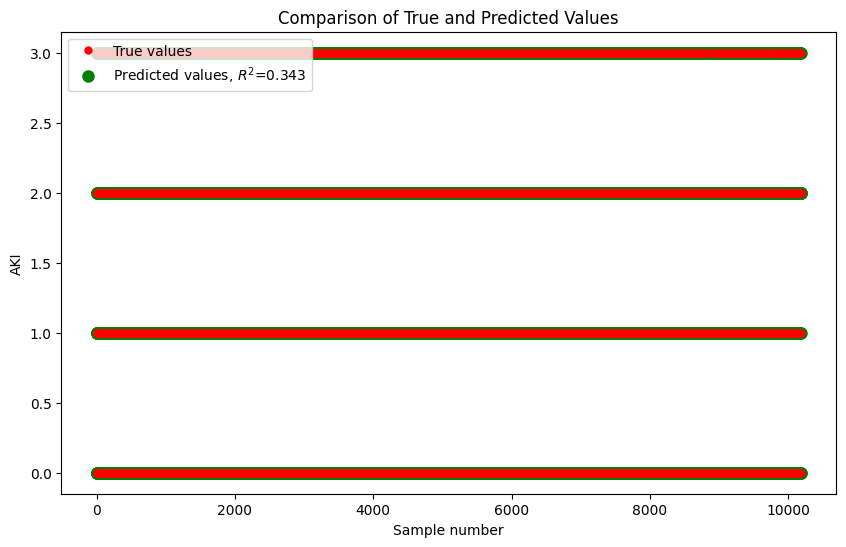

Accuracy on validation set: 0.3429890023566379


In [18]:
clt = DecisionTreeClassifier(random_state=42)
model1 = clt.fit(X_train_selected, y_train)
y_pre1 = clt.predict(X_valid_selected)
print(y_pre1)
print(y_valid)

test_validate(X_valid_selected, y_valid=y_valid, y_predict=y_pre1, classifier=clt)
r = clt.score(X_valid_selected, y_valid)
print("Accuracy on validation set:", r)

In [19]:
y_pred_proba1 = clt.predict_proba(X_valid_selected)

roc_auc = roc_auc_score(y_valid, y_pred_proba1, multi_class='ovr')  # 或者使用 'ovo'

result1 = classification_report(y_valid, y_pre1)
con_matrix = confusion_matrix(y_valid, y_pre1)
print("Classification report:")
print(result1)
print('Confusion matrix:\n', con_matrix)
print('Accuracy: {}'.format(accuracy_score(y_valid, y_pre1)))
print('Precision: {}'.format(precision_score(y_valid, y_pre1, average='weighted')))
print('Recall: {}'.format(recall_score(y_valid, y_pre1, average='weighted')))
print('F1-score: {}'.format(f1_score(y_valid, y_pre1, average='weighted')))
print("ROC AUC: {}".format(roc_auc))

Classification report:
              precision    recall  f1-score   support

         0.0       0.44      0.44      0.44      3400
         1.0       0.20      0.20      0.20      2028
         2.0       0.35      0.36      0.36      3162
         3.0       0.29      0.29      0.29      1594

    accuracy                           0.34     10184
   macro avg       0.32      0.32      0.32     10184
weighted avg       0.34      0.34      0.34     10184

Confusion matrix:
 [[1494  640  932  334]
 [ 720  397  645  266]
 [ 866  616 1140  540]
 [ 334  290  508  462]]
Accuracy: 0.3429890023566379
Precision: 0.34167950232203553
Recall: 0.3429890023566379
F1-score: 0.34230431416242774
ROC AUC: 0.5479162938521331


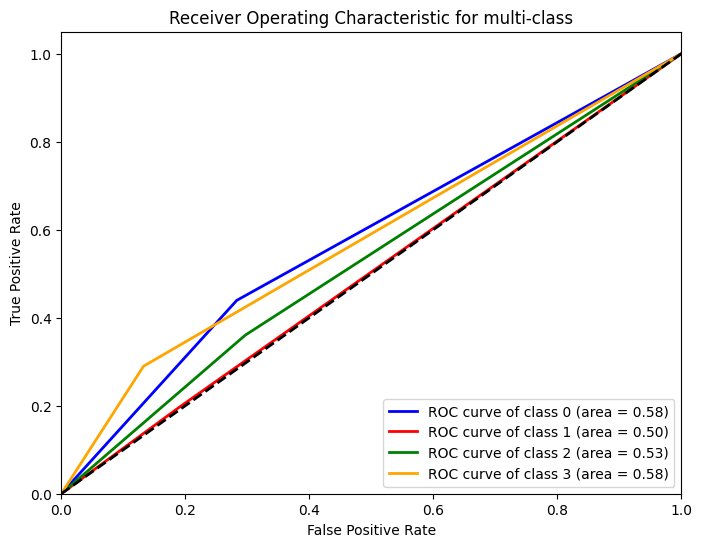

In [20]:
y_valid_binarized = label_binarize(y_valid, classes=np.unique(y_valid))

n_classes = y_valid_binarized.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_valid_binarized[:, i], y_pred_proba1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['blue', 'red', 'green', 'orange', 'black', 'purple'])
plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class')
plt.legend(loc="lower right")
plt.show()


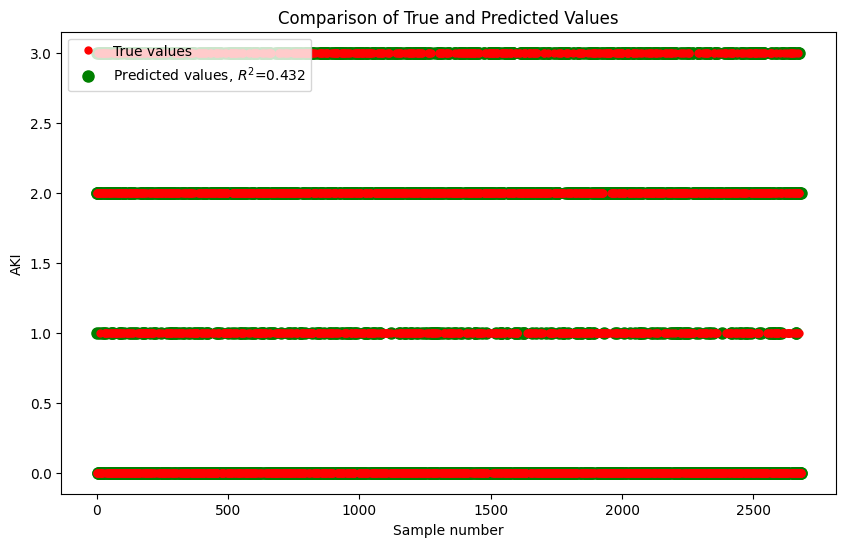

Accuracy on validation set: 0.43214019388516034


In [9]:
clr = LogisticRegression(random_state=42, max_iter=1000,
                         class_weight='balanced',
                         C=1,
                         solver='saga',
                         penalty='l1'
                        )

model3 = clr.fit(X_train_selected, y_train)
y_pre3 = clr.predict(X_valid_selected)

test_validate(X_valid=X_valid_selected, y_valid=y_valid, y_predict=y_pre3, classifier=clr)

r = clr.score(X_valid_selected, y_valid)
print("Accuracy on validation set:", r)

In [11]:
y_pred_proba3 = clr.predict_proba(X_valid_selected)

roc_auc3 = roc_auc_score(y_valid, y_pred_proba3, multi_class='ovr')  # 或者使用 'ovo'

result3 = classification_report(y_valid, y_pre3)
con_matrix = confusion_matrix(y_valid, y_pre3)
print("Classification report:")
print(result3)
print('Confusion matrix:\n', con_matrix)
print('Accuracy: {}'.format(accuracy_score(y_valid, y_pre3)))
print('Precision: {}'.format(precision_score(y_valid, y_pre3, average='weighted')))
print('Recall: {}'.format(recall_score(y_valid, y_pre3, average='weighted')))
print('F1-score: {}'.format(f1_score(y_valid, y_pre3, average='weighted')))
print("ROC AUC: {}".format(roc_auc3))

Classification report:
              precision    recall  f1-score   support

         0.0       0.54      0.59      0.56       918
         1.0       0.21      0.11      0.14       512
         2.0       0.43      0.42      0.42       844
         3.0       0.35      0.52      0.41       408

    accuracy                           0.43      2682
   macro avg       0.38      0.41      0.39      2682
weighted avg       0.41      0.43      0.42      2682

Confusion matrix:
 [[542  79 190 107]
 [187  55 173  97]
 [203  96 351 194]
 [ 75  28  94 211]]
Accuracy: 0.43214019388516034
Precision: 0.4143336410749595
Recall: 0.43214019388516034
F1-score: 0.4168646537505678
ROC AUC: 0.6610660481291165


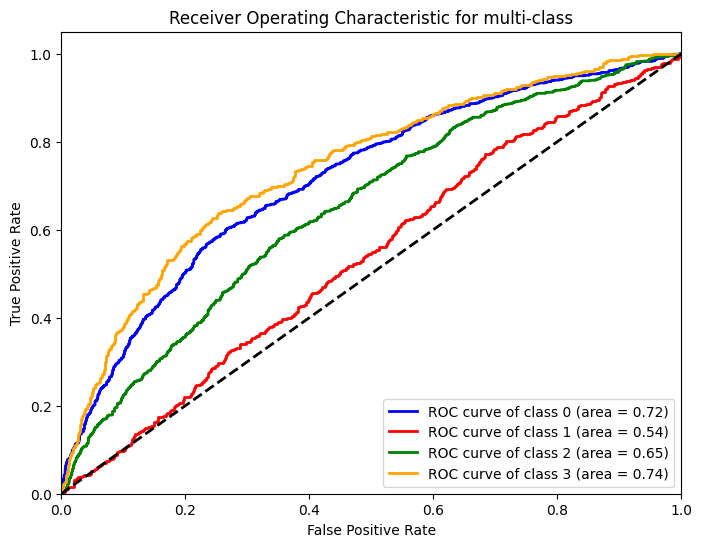

In [12]:
y_valid_binarized = label_binarize(y_valid, classes=np.unique(y_valid))

n_classes = y_valid_binarized.shape[1]

fpr = dict()
tpr = dict()
roc_auc3 = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_valid_binarized[:, i], y_pred_proba3[:, i])
    roc_auc3[i] = auc(fpr[i], tpr[i])

colors = cycle(['blue', 'red', 'green', 'orange', 'black', 'purple'])
plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc3[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class')
plt.legend(loc="lower right")
plt.show()

In [13]:
cls= svm.SVC(
        C=1.0,
        cache_size=500,
        class_weight='balanced',
        coef0=0.3,
        degree=5,
        gamma='scale',
        kernel='rbf',
        max_iter=-1,
        probability=True,
        random_state=42,
        shrinking=True,
        tol=0.000001,
        verbose=False)

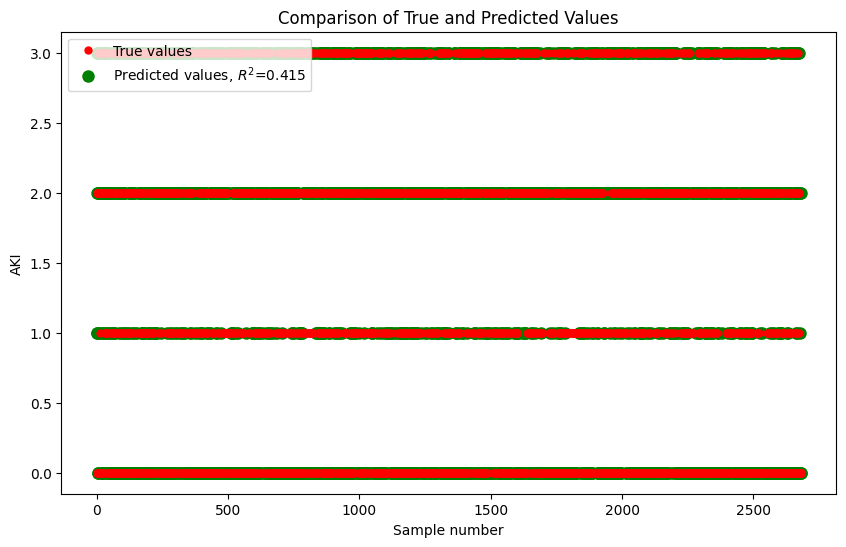

Accuracy on validation set: 0.4236039899319474


In [14]:
model2 = cls.fit(X_train_selected, y_train)
y_pre2 = cls.predict(X_valid_selected)

test_validate(X_valid=X_valid_selected, y_valid=y_valid, y_predict=y_pre2, classifier=cls)

r = cls.score(X_train_selected, y_train)
print("Accuracy on validation set:", r)

In [15]:
y_pred_proba2 = cls.predict_proba(X_valid_selected)

roc_auc2 = roc_auc_score(y_valid, y_pred_proba2, multi_class='ovr')

result2 = classification_report(y_valid, y_pre2)
con_matrix = confusion_matrix(y_valid, y_pre2)
print("Classification report:")
print(result2)
print('Confusion matrix:\n', con_matrix)
print('Accuracy: {}'.format(accuracy_score(y_valid, y_pre2)))
print('Precision: {}'.format(precision_score(y_valid, y_pre2, average='weighted')))
print('Recall: {}'.format(recall_score(y_valid, y_pre2, average='weighted')))
print('F1-score: {}'.format(f1_score(y_valid, y_pre2, average='weighted')))
print("ROC AUC: {}".format(roc_auc2))

Classification report:
              precision    recall  f1-score   support

         0.0       0.52      0.51      0.51       918
         1.0       0.22      0.13      0.16       512
         2.0       0.42      0.44      0.43       844
         3.0       0.36      0.52      0.42       408

    accuracy                           0.41      2682
   macro avg       0.38      0.40      0.38      2682
weighted avg       0.40      0.41      0.41      2682

Confusion matrix:
 [[466 115 230 107]
 [168  67 181  96]
 [203  94 368 179]
 [ 64  32 101 211]]
Accuracy: 0.4146159582401193
Precision: 0.40428345407840044
Recall: 0.4146159582401193
F1-score: 0.4050495802078517
ROC AUC: 0.660402239939484


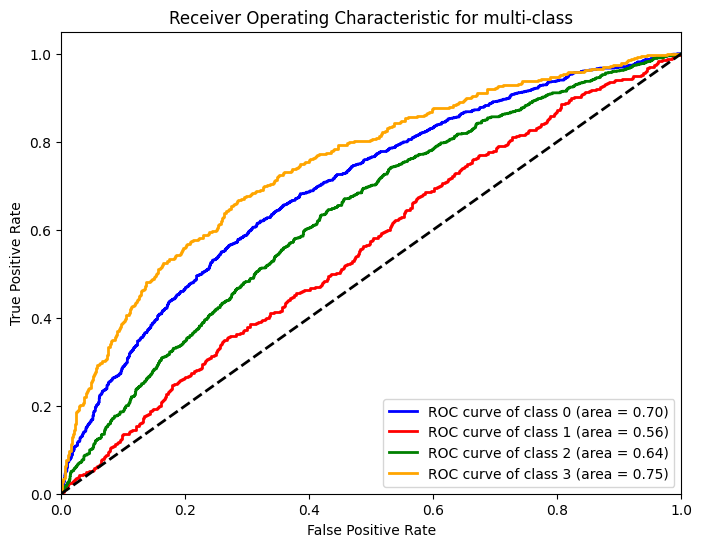

In [16]:
y_valid_binarized = label_binarize(y_valid, classes=np.unique(y_valid))

n_classes = y_valid_binarized.shape[1]

fpr = dict()
tpr = dict()
roc_auc2 = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_valid_binarized[:, i], y_pred_proba2[:, i])
    roc_auc2[i] = auc(fpr[i], tpr[i])

colors = cycle(['blue', 'red', 'green', 'orange', 'black', 'purple'])
plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc2[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class')
plt.legend(loc="lower right")
plt.show()